1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, log_loss, roc_auc_score, average_precision_score, confusion_matrix
from ELI5 import PermutationImportance
from sklearn.ensemble import RandomForestClassifier

In [2]:
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

In [3]:
def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=-1,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf, f1_test

In [11]:
def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

In [8]:
%%time
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.3).fit_sample(X_train, y_train)

Wall time: 25.1 s


Взаимная информация

In [9]:
mi = mutual_info_classif(X_train_balanced, y_train_balanced)

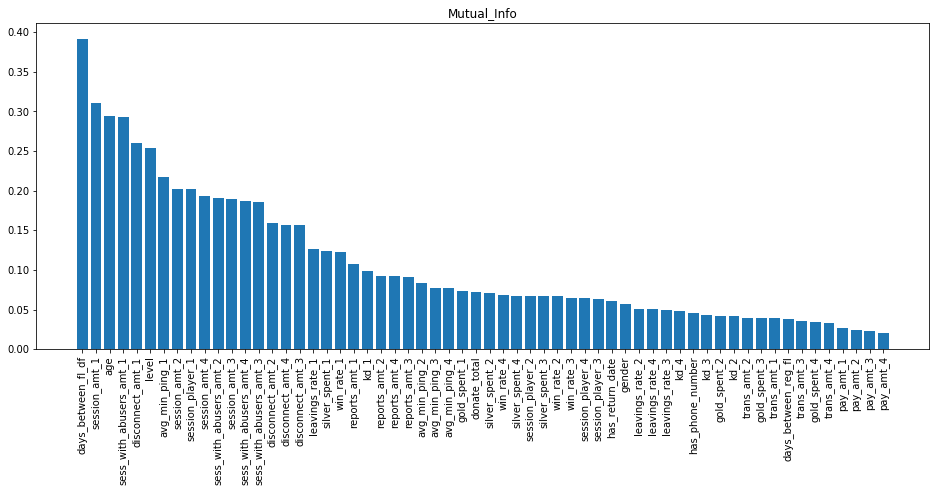

In [12]:
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [13]:
X_train_mi = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_mi = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

In [14]:
fitted_clf = xgb_fit_predict(X_train_mi, y_train_balanced, X_test_mi, y_test)

Precision: 0.29243318292259635
Recall: 0.4062198649951784
F1: 0.34006054490413723
Log Loss: 0.1342371066456897
ROC AUC: 0.8951090222504733


RFE 

In [17]:
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 50


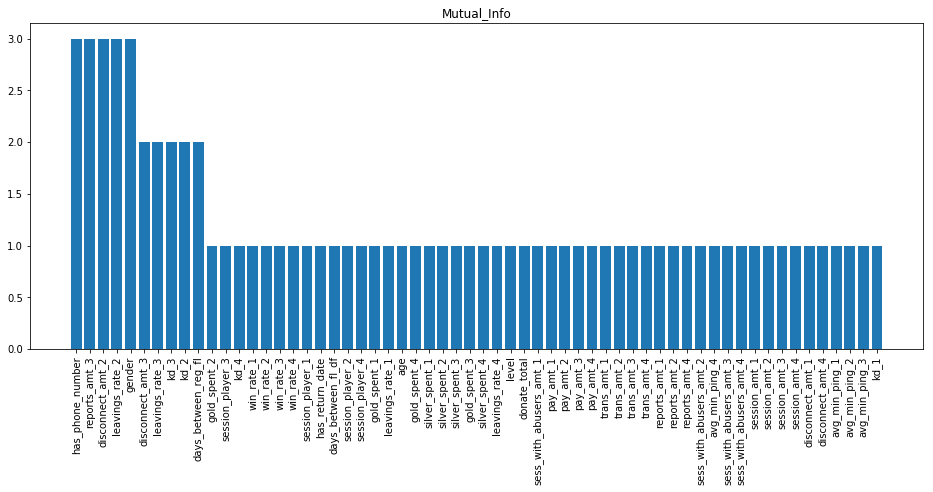

In [18]:
feature_importance = plot_importance(selector.ranking_, X.columns, 'Mutual_Info')

In [19]:
X_train_rfe = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_rfe = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_rfe, y_train_balanced, X_test_rfe, y_test)

Precision: 0.2870936594785967
Recall: 0.43008678881388623
F1: 0.3443350704497201
Log Loss: 0.13594830805932462
ROC AUC: 0.8967121299934184


PI

In [23]:
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.2941948179731059
Recall: 0.4324975891996143
F1: 0.3501854382197931
Log Loss: 0.13335087791640302
ROC AUC: 0.8987857163794006


In [26]:
%%time
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

TypeError: not all arguments converted during string formatting

Вроде делаю все как на уроке но выходит ошибка, не могу понять почему

2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

In [28]:
rfe = LogisticRegression(random_state=42).fit(X_train_rfe, y_train_balanced)

In [30]:
predict_proba_test = rfe.predict_proba(X_test_rfe)
predict_test = rfe.predict(X_test_rfe)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.20676086567698085
Recall: 0.2786885245901639
F1: 0.23739603655406097
Log Loss: 0.2575090209959996
ROC AUC: 0.7747836381828735


In [31]:
rfe_2 = RandomForestClassifier(max_depth=3, random_state=42).fit(X_train_rfe, y_train_balanced)

In [32]:
predict_proba_test = rfe_2.predict_proba(X_test_rfe)
predict_test = rfe_2.predict(X_test_rfe)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.2392358140861135
Recall: 0.40453230472516877
F1: 0.30066296362659023
Log Loss: 0.2055270790226198
ROC AUC: 0.884893765526819


3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

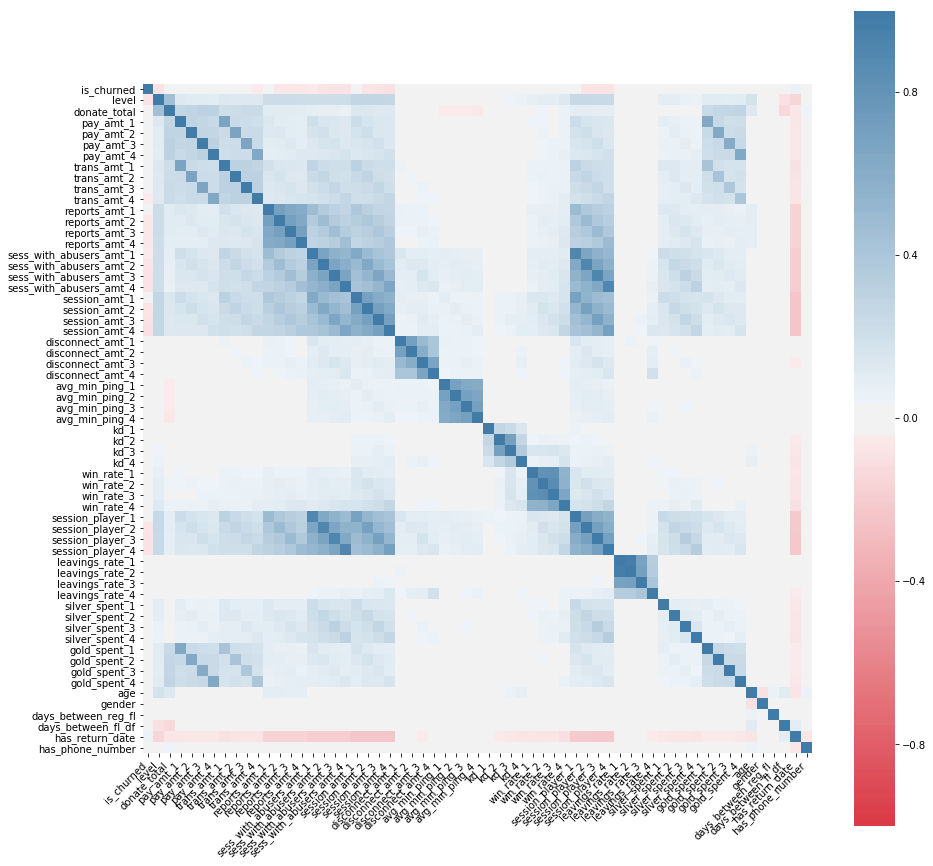

In [35]:
corr = dataset.drop(['user_id'], axis=1).corr()
plt.figure(figsize=(15, 15))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(10, 240, n=200),square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
plt.show()

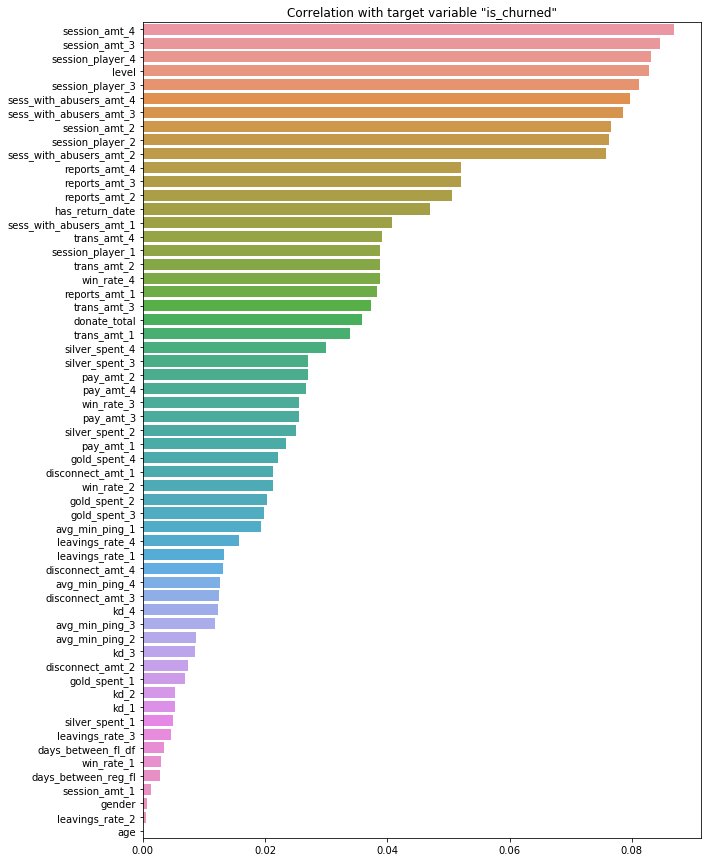

In [36]:
corr_with_target = np.abs(corr.iloc[:-1, 0].drop('is_churned')).sort_values(ascending=False)
plt.figure(figsize=(10, 15))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable "is_churned"')
plt.show()

In [38]:
X_train_CORR = pd.DataFrame(X_train_balanced, columns=X.columns)[corr_with_target[:35].index]
X_test_CORR = pd.DataFrame(X_test, columns=X.columns)[corr_with_target[:35].index]

In [39]:
fitted_clf = xgb_fit_predict(X_train_CORR, y_train_balanced, X_test_CORR, y_test)

Precision: 0.2880694912249601
Recall: 0.39175506268081
F1: 0.33200531208499334
Log Loss: 0.14325202191468303
ROC AUC: 0.8384477556567436
